In [1]:
%%HTML
<script src="require.js"></script>

In [58]:
from IPython.display import display, HTML, clear_output
HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

<img src='Pictures/job_banners_dmw.webp'/>

<a id='Abstract'></a>
<img class='header' src='Pictures/abstract.png'/>

The Data Science, Analytics, and Engineering job sector has experienced substantial growth, creating opportunities for both companies and specialists. Navigating this dynamic field is a continual challenge as professionals adapt their skills to evolving industry demands. This study focuses on identifying pivotal skills for roles in the Philippine data industry, providing aspiring professionals with insights for strategic skill development and targeted career growth. Data from JobStreet PH, a prominent online hiring platform, was used, and dimensionality reduction techniques revealed key job segments and their associated skills. In the result, the study shows the importance of not only technical proficiency (SQL, Excel) but also soft skills and core competencies, such as strong communication, client interaction, and customer-centricity. It can be concluded that for professionals to thrive across industries in the Philippines, it is not only important to be technically knowledgeable, but also have soft skills such as communication and client management.

<a id='Libraries'></a>
<img class='header' src='Pictures/import.png'/>

<h2 style="color: #C00000">Import Libraries</h2>
<p>The following libraries and functions were imported:</p>
<ul>
    <li><b>Pandas</b> for managing dataframes and tabular data</li>
    <li><b>sklearn's TfidfVectorizer</b> for vectorizing the tokens and normalizing them into TF-IDF</li>
    <li><b>Numpy</b> for faster manipulation of matrices</li>
    <li><b>matplotlib's pyplot</b> for plotting some of the relevant visualizations in the paper</li>
    <li><b>SQLite3</b> for accessing and querying created databases</li>
    <li><b>Regular Expression</b> for acquiring the skills from the job descriptions</li>
    <li><b>Collections' Counter</b> for collecting frequencies for the word cloud</li>
    <li><b>Sklearn's English Stop Words</b> for additional stop words to add to the vectorizer</li>
    <li><b>Warnings</b> for hiding the warnings and making the notebook cleaner</li>
    <li><b>Seaborn</b> for plotting the other relevant visualizations in the paper</li>
    <li><b>WordCloud</b> for getting the stop words, generating the word cloud, and generating image color</li>
    <li><b>IPython</b> for displaying purposes</li>
    <li><b>json</b> for parsing json-like columns</li>
</ul>

In [136]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import warnings
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json

<h2 style="color: #C00000">Define Functions</h2>
<p>The following functions were defined:</p>
<ul>
    <li><b>truncated_svd</b> for performing Singular Value Decomposition on the given design matrix</li>
    <li><b>project_svd</b> for projecting the relevant singular values on the design matrix</li>
    <li><b>plot_svd</b> for plotting the transformed data and features on to the first two singular vectors</li>
    <li><b>grey_color_func</b> for generating color in varying shades of gray for a given word in the word cloud</li>
    <li><b>parse_classification</b> for parsing classifications from the given list of classifications</li>
    <li><b>parse_location</b> for parsing locations from the given list of locations</li>
    <li><b>remove_empty_strs</b> for removing empty strings in the `skill` column</li>
    <li><b>word_cloud_svd</b> for creating word clouds for the features of the singular values</li>
    <li><b>nssd_cum</b> for plotting the cumulative nssd and finding the significant number of singular values at a given threshold</li>
    <li><b>color</b> for deciding the color of each word in each singular value's word cloud</li>
</ul>

In [570]:
def truncated_svd(X):
    """
    Accept the design matrix and return the q, sigma, p, and the normalized
    sum of squared distance from the origin.

    Parameters
    ----------
    X : array-like
        Design matrix
    
    Returns
    ----------
    q : array-like
        Q
    
    sigma : array-like
        Singular values
    
    p : array-like
        P
        
    nssd : array-like
        Normalized sum of square distance from the origin
    """
    q, sigma, p = np.linalg.svd(X)
    p = p.T
    s_diag = np.diag(sigma)
    nssd = (sigma**2) / np.sum(sigma**2)
    return q, s_diag, p, nssd

In [571]:
def project_svd(q, s, k):
    """
    Accept q, s, and k, and return the design matrix projected on to the first
    k singular vec

    Parameters
    ----------
    X : array-like
        Design matrix
    
    Returns
    ----------
    X_new : array-like
        Rotated design matrix
    
    w : array-like
        New coordinate system
    
    variance_explained : array-like
        Variance explained
    """
    Q_truncated = q[:, :k]
    Sigma_truncated = s[:k, :k]
    Q_projected = np.dot(Q_truncated, Sigma_truncated)
    return Q_projected

In [572]:
def plot_svd(X_new, features, p):
    """
    Plot transformed data and features on to the first two singular vectors

    Parameters
    ----------
    X_new : array
        Transformed data
    features : sequence of str
        Feature names
    p : array
        P matrix
    """
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.4), dpi=150)
    ax[0].scatter(X_new[:,0], X_new[:,1])
    ax[0].set_xlabel('SV1')
    ax[0].set_ylabel('SV2')

    for feature, vec in zip(features, p):
        ax[1].arrow(0, 0, vec[0], vec[1], width=0.001, ec='none', fc='skyblue')
        ax[1].text(vec[0], vec[1], feature, ha='center', color='black', fontsize=5)
    ax[1].set_xlabel('SV1')
    ax[1].set_ylabel('SV2')

In [573]:
def grey_color_func(word,
                    font_size,
                    position,
                    orientation,
                    random_state=None,
                    **kwargs):
    """
    Generate a color in varying shades of gray for a given word.

    Parameters
    ----------
    word : str
        Word
        
    font_size : int
        Font size
    
    position : int
        Position
        
    orientation : int
        Orientation
        
    random_state : int
        Random state
        
    **kwargs
        Additional arguments

    Returns:
    ----------
    str 
        An HSL color string representing a shade of gray.
    """
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

In [295]:
def parse_classification(classification_str):
    """
    Parse classification of jobs from dict-like data.

    Parameters
    ----------
    classification_str : array-like
        Dict-like string
    
    Returns
    ----------
    id_part : str
        ID part of string
        
    description_part : str
        Description part of string
    """
    parts = classification_str.strip("{}").split("', '")

    id_part = parts[0].split(": ")[1].strip("'")
    description_part = parts[1].split(": ")[1].strip("'")

    return id_part, description_part

In [296]:
def parse_location(location_str):
    """
    Parse locations  from dict-like data.

    Parameters
    ----------
    location_str : array-like
        Dict-like string
    
    Returns
    ----------
    label : str
        Label part of location
        
    countryCode : str
        Country code
        
    seoHierarchy : str
        Hierarchy in terms of Search Engine Optimization (SEO)
    """
    location_dict = json.loads(location_str.replace("'", '"'))

    label = location_dict.get("label", "")
    countryCode = location_dict.get("countryCode", "")
    seoHierarchy = json.dumps(location_dict.get("seoHierarchy", []))

    return label, countryCode, seoHierarchy

In [297]:
def remove_empty_strs(df):
    """
    Remove empty strings from dataframe.

    Parameters
    ----------
    df
        Dataframe
    
    Returns
    ----------
    df
        Dataframe
    """
    rows_to_drop = df[df['skill']==''].index
    df.drop(rows_to_drop, inplace=True)
    return df

In [614]:
def word_cloud_svd(num):
    """
    Create word cloud from `p` from the decomposed matrix, where the weights of
    each token is acquired from p.

    Parameters
    ----------
    num
        Number of SV minus one
    """
    order = np.argsort(np.abs(p[:, num]))[-15:]
    weight = np.abs(p[:, num][order])
    weight_check = p[:, num][order]
    word_could_dict = Counter(feature_names[order])
    global lst_negativity 
    lst_negativity = []
    global lst_positivity
    lst_positivity = []
    for (keys, values), i, sign in zip(word_could_dict.items(), weight, 
                                       weight_check):
        word_could_dict[keys] *= 100 * i
        word_could_dict[keys] = int(word_could_dict[keys])
        if sign > 0:
            lst_positivity.append(keys)
        else:
            lst_negativity.append(keys)
    wordcloud = WordCloud(color_func=color,width=2000, height=1200, margin=3, 
                          scale=1, prefer_horizontal=0.7,
                          background_color='white', 
                          relative_scaling=0.000001).generate_from_frequencies(
        word_could_dict)
    plt.imshow(wordcloud)
    plt.title(f"SV {num + 1}")
    plt.axis("off")
    plt.show()

In [364]:
def nssd_cum(nssd):
    """
    Plot normalized sum of squared differences (nssd) and cumulative sum of
    nssd.

    Parameters
    ----------
    nssd
        Normalized sum of squared differences
    """
    fig, ax = plt.subplots()
    ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
    ax.set_xlim(0, len(nssd)+1)
    ax.set_xlabel('SV')
    ax.set_ylabel('variance explained')
    ax = ax.twinx()
    ax.plot(range(1, len(nssd)+1), nssd.cumsum(), 'r-', label='cumulative')
    ax.axhline(0.8, ls='--', color='g')
    ax.axvline(70, ls='--', color='g')
    ax.set_ylabel('cumulative variance explained')
    ax.set_title('Variance Explained vs. Cum. Variance Explained')
    plt.show()

In [606]:
def color(word, font_size, position, orientation, font_path, random_state):
    """
    Signify which color to use for a given word.

    Parameters
    ----------
    word : str
        Word
        
    font_size : int
        Font size
        
    position : int
        Position
        
    orientation: int
        Orientation
        
    font_path : int
        Font Path
        
    random_state : int
        Random state
    
    Returns
    ----------
    str
        Hex color code
    """
    if word in lst_positivity and word in df_classification.columns:
        return '#C06832'
    elif word in lst_positivity and word in skills_df.columns:
        return '#FF8A47'
    elif word in lst_negativity and word in df_classification.columns:
        return '#412395'
    else:
        return '#B298FC'

<a id='TContents'></a>
<img class='header' src='Pictures/table_contents.png'/>

[ABSTRACT](#Abstract) <br> 
[IMPORT LIBRARIES AND DEFINE FUNCTIONS](#Libraries) <br>
[I. PROBLEM STATEMENT](#Problem) <br> 
[II. MOTIVATION](#Motivation) <br> 
[III. DATA SOURCE](#DataSrc) <br> 
[IV. DATA EXPLORATION](#DataExp) <br> 
[V. METHODOLOGY](#Method) <br> 
[VI. RESULTS AND DISCUSSION](#Results) <br> 
[VII. CONCLUSION](#Conclusion) <br> 
[VIII. RECOMMENDATION](#Recommendation) <br> 
[ACKNOWLEGMENT](#Acknowledgment) <br>
[REFERENCES](#References) <br> 

<a id='Problem'></a>
<img class='header' src='Pictures/problem.png'/>

<p>The Data Science, Analytics, and Engineering job industry has been growing rapidly in the past decade. This industry presents a huge opportunity for growth and development for companies and specialists alike, but can serve as a challenge for data professionals to know what companies need and for companies to know what data professionals do. While there may be indeed unicorns in the industry who may assume every possible role in the industry, they are a rarity, and it has been considered counterproductive to assume that every data professional is a unicorn, who possesses all relevant data skills and “can do everything needed by the company” (Davenport & Patil, 2022).</p>

<p>Hence, by identifying the current, in-demand job clusters, we may know how the data industry is developing to make practical use of the data that they have and how they are making the best use of existing expertise. Furthermore, we can direct our own development to include the critical skills for the specific job segments we are entering in the industry to remain both competitive and on the leading edge of where this technology is developing.</p>

<p>Ultimately, this study aims to address the question: <b>What are the current, in-demand job segments of the Philippine Data Industry, and what corresponding skills are most needed in each job segment?</b></p>

[Back to TOC](#TContents)

<a id='Motivation'></a>
<img class='header' src='Pictures/motivation.png'/>

<p>
    The evolving landscape of the job market, particularly in the aftermath of the global pandemic, presents a compelling context for our study. In the Philippines, the job market has undergone significant transformations. Phenomena such as the Great Resignation and Quiet Quitting have led to what can be described as an 'Invisible Revolution' in employment trends (Page, 2023). These shifts not only underscore the urgency to understand the current state of job markets but also highlight the unique dynamics within sectors like data science and analytics. <b>Our study aims to delve into this evolving landscape, focusing on the in-demand job segments and the requisite skills in the data industry, a domain that remains partially explored in existing literature.</b> </p>
<p>
    This necessity is further amplified by the changing attitudes and motivations of employees across industries. The decline in job loyalty and the continuous search for better opportunities signal a shift in employee mindset, validating the importance of our study in identifying sought-after roles and skills in the data science domain (Page, 2023). Understanding these elements is paramount for professionals navigating this new era of employment, where flexibility and career growth are key drivers. Our study bridges these gaps, providing insights that are not only academic in nature but also practical for career planning and organizational development. </p>
<p>
    Furthermore, the growing emphasis on work-life balance and flexibility in job roles has become a critical aspect of employee satisfaction and retention. This shift in preferences underscores the need to comprehend the evolving nature of job roles, particularly in the data science sector, and their offerings in terms of flexibility and work-life balance (Page, 2023). <b>Our study directly responds to these trends, examining how these factors influence the data science job market in the Philippines.</b> </p>
<p>
    The increased demand for data science roles reinforces the relevance of our research. As industries become more data-driven, the need for skilled data scientists and analysts is more pronounced than ever. These professionals are essential in unlocking insights from vast, unprocessed data streams, making their roles critical in contemporary business operations (Page, 2023). <b>By identifying specific skills and roles in demand, our study not only contributes to academic discourse but also provides a practical guide for aligning educational and professional development with market needs.</b> </p>
<p>
    <b>Our study is positioned at a critical juncture, where understanding the dynamics of the data science job market is essential for both professionals and organizations.</b> It is uniquely poised to offer valuable insights into the development of the data industry in the Philippines, guiding individuals and organizations in navigating and strategizing their career paths and talent management in this new era of work. The implications of our findings extend beyond academia, offering practical applications for a workforce in transition. </p>
    
[Back to TOC](#TContents)

<a id='DataSrc'></a>
<img class='header' src='Pictures/data_source.png'/>

<h2 style="color: #C00000">Data Source</h2>

JobStreet PH `(https://www.jobstreet.com.ph/)` is a leading hiring platform in the Philippines, which caters to job seekers and employers. JobStreet is known for its comprehensive listings across various industries and sectors, making it a valuable resource for labor market analysis.

Job postings were scraped from this hiring platform for data-related job posts. The scraped data comprised of 10,608 job listings, with 37 features, including the job title, job details, company details, and job location. After cleanup and preprocessing, and removing unnecessary columns, the final data was reduced to 2,681 rows with 15 features. 


<h2 style="color: #C00000">Data Description</h2>

Our first set of scraped data consists of 37 features which are: `advertiser`, `automaticInclusion`, `branding`, `bulletPoints`, `classification`, `companyName`, `companyProfileStructuredDataId`, `displayStyle`, `displayType`, `listingDateDisplay`, `location`, `locationId`, `locationWhereValue`, `id`, `isPremium`, `isStandOut`, `jobLocation`, `listingDate`, `logo`,`roleId`, `salary`, `solMetadata`, `subClassification`, `teaser`, `title`, `tracking`, `workType`, `isPrivateAdvertiser`, `tags`, `currencyLabel`, `suburb`, `suburbId`, `suburbWhereValue`, `searchInsights`, `area`, `areaId`, `areaWhereValue`.

We refined our initial dataset of 37 features obtained from the first scraping, narrowing it down to a more focused set of 15 key features. This selection process was guided by the relevance of each feature to our study's objectives, ensuring that the refined dataset is both comprehensive and directly aligned with our research goals. The features retained are:

<ul>
    <li>`id` - The unique identifier for each job listing</li>
    <li>`jobTitle` - The specific title of the job</li>
    <li>`jobDetails` - An in-depth description of the job</li>
    <li>`teaser` - A concise summary of the job_details</li>
    <li>`roleId` - Categories defining the job's nature and domain</li>
    <li>`classification` - Categories defining the job's nature and domain</li>
    <li>`subClassification` - Subcategories defining the job's nature and domain</li>
    <li>`workType` - Denoting whether the job is full-time, part-time, or contractual.</li>
    <li>`companyName` - Name of the company</li>
    <li>`location` - Location of the job</li>
    <li>`suburb` - District of the location</li>
    <li>`jobLocation` - Address or the region of the job</li>
    <li>`averageSalary` - Average salary of the job, derived from the range of 'salary'</li>
    <li>`currency` - Currency of the salary</li>
    <li>`payScheme` - Payment scheme if monthly, daily</li>
</ul>
    
In the end, these were reduced further to two columns, a TF-IDF vectorized `skill` column derived from the `jobDetails` column and columns from the one-hot encoded `classification` column.

<a id='DataExp'></a>
<img class='header' src='Pictures/data_explore.png'/>

<h2 style="color: #C00000">Data Exploration</h2>

<p>
    This phase of our study is foundational to achieving these objectives. Here, we meticulously analyze the raw data collected from JobStreet PH, a leading job platform in the Philippines. This phase is dedicated to unraveling the layers of our dataset, which includes information on thousands of job listings across the data field. By scrutinizing each aspect of the data, from job titles and locations to detailed job descriptions, we aim to paint a comprehensive picture of the current job market in the data industry.

<p>
    Through this exploration, we strive to lay a solid foundation for answering our central research question: What are the current, in-demand job segments in the Philippine Data Industry, and what specific skills are most needed in each of these segments? By meticulously dissecting our dataset, we prepare the groundwork for more sophisticated analyses that will follow, ultimately guiding individuals and organizations towards more informed decisions in the ever-evolving realm of data science and analytics. </p>

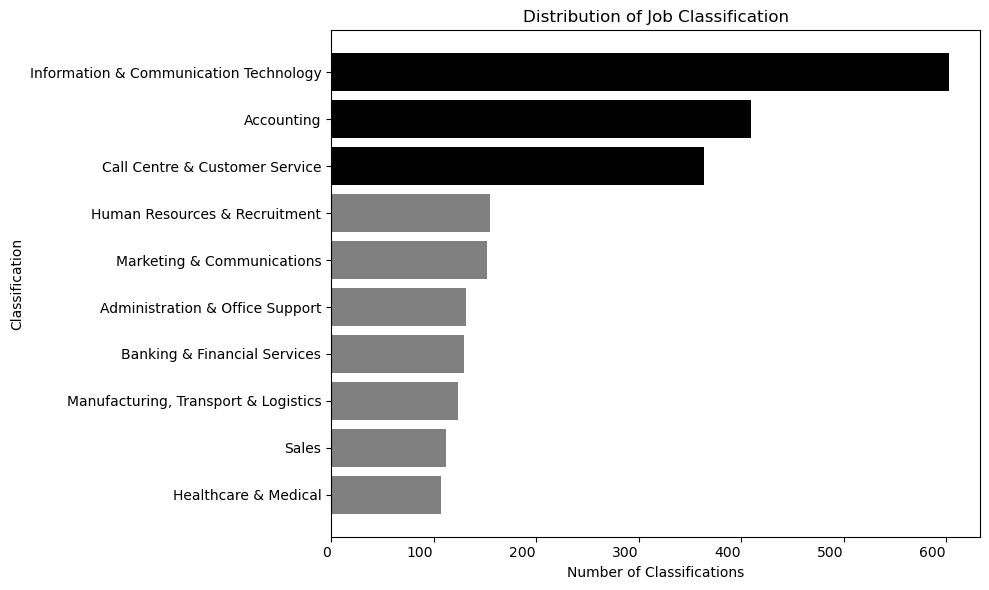

In [114]:
warnings.filterwarnings("ignore", category=FutureWarning)

classification = df_explore['classification'].value_counts(
    ).head(10).sort_values()

plt.figure(figsize=(10, 6))
plt.barh(classification.index,
        classification.values,
        color=['gray', 'gray', 'gray', 'gray', 'gray',
               'gray', 'gray', 'black', 'black', 'black',])

plt.xticks(rotation=0, ha='right')
plt.xlabel('Number of Classifications')
plt.ylabel('Classification')
plt.title('Distribution of Job Classification')

# Display the plot
plt.tight_layout()
plt.show()

<center><b>Figure 1.</b> Distribution of Job Classifications</center>

As seen above, most of the jobs are comprised of Information & Communication Technology, Accounting, and Call Centre and Customer Service. Hence, it can be inferred from this that these groups would have a large effect on the grouping done by SVD.

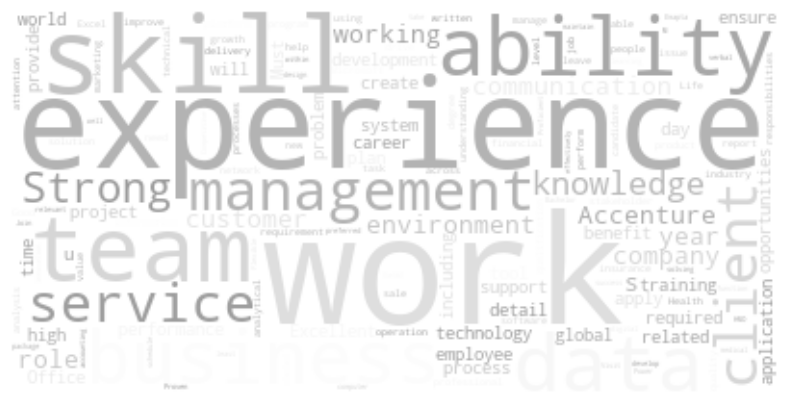

In [44]:
combined_text = " ".join(review for review in df['skill'].dropna())

wordcloud = WordCloud(background_color="white",
                      collocations=False).generate(combined_text)

wordcloud.recolor(color_func=grey_color_func)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<center><b>Figure 2.</b> Word Cloud of `jobDescription` Column</center>

Moreover, in Figure 2, most "skills" are general words such as management, experience, work, and skill, and so, domain-specific stop words should be set in place when vectorizing this column, as these would not have much value when analyzing the groups produced by SVDs which contain these words.

[Back to TOC](#TContents)

<a id='Method'></a>
<img class='header' src='Pictures/methodology.png'/>

<img class='header' src='Pictures/method-v2.png'/>

The methodology consisted of <b>3 phases</b>:
    <ol>
    <li>Data Collection</li>
    <li>Data Preprocessing</li>
    <li>Dimensionality Reduction & Analysis</li>
    </ol>

<h2 style="color: #C00000">Data Collection</h2>
The Data Collection phase consisted of 2 parts: webscraping of data-related jobs from JobStreet (1), and webscraping the `job_details` or job description of those jobs.

<img class='header' src='Pictures/jobstreet.png'/>

<center><b>Figure 3.</b> Distribution of Job Classifications</center>

<p>
    For the data, the group utilized JobStreet PH, a leading hiring platform in the Philippines, catering to job seekers and employers. JobStreet is known for its comprehensive listings across various industries and sectors, making it a valuable resource for labor market analysis. </p>

<p>
    The data collection process began with a targeted search on JobStreet PH. The group initiated a query using the keyword 'data' coupled with a geographical filter set to 'Philippines'. This search strategy was designed to yield a wide range of job opportunities related to 'data' across various industries in the Philippines. The results from this query were extensive, reflecting the diverse and dynamic nature of the data-related job market in the country. </p>



```python
js_params = {
    'siteKey':'PH-Main',
    'sourcesystem':'houston',
    'userqueryid':'29f535e70ed6837e41115b411d0e4f34-0245335',
    'userid':'1430f579-f0af-4b9a-b969-77535c91cc72',
    'usersessionid':'1430f579-f0af-4b9a-b969-77535c91cc72',
    'eventCaptureSessionId':'1430f579-f0af-4b9a-b969-77535c91cc72&',
    'where':'Philippines',
    'page':'1',
    'seekSelectAllPages':'true',
    'keywords':'data',
    'pageSize':'100',
    'include':'seodata',
    'locale':'en-PH',
    'solId':'cf9086ae-797a-4772-8f88-8dd47c63fad0'
}

js_joblist = []

for pagenum in range(0, 105):
    js_params['page'] = str(pagenum)

    response = requests.get(
        'https://www.jobstreet.com.ph/api/chalice-search/v4/search',
        headers=js_headers,
        params=js_params
    )

    time.sleep(1)
    
    js_joblist.extend(response.json()['data'])
```

<center><b>Figure 4.</b> Web Scraping Code Using JobStreet API</center>

<p><b>Table 1.</b></p>
<p><i>Preview of the Preliminary DataFrame</i></p>

In [209]:
conn = sqlite3.connect('jobs_final.db')

In [210]:
df_raw = pd.read_sql('SELECT * FROM jobs_raw', conn)
df_raw.head(3)

,advertiser,automaticInclusion,branding,bulletPoints,classification,companyName,companyProfileStructuredDataId,displayStyle,displayType,listingDateDisplay,...,isPrivateAdvertiser,tags,currencyLabel,suburb,suburbId,suburbWhereValue,searchInsights,area,areaId,areaWhereValue
0,"{'id': '60350712', 'description': 'ISTA Soluti...",0,{'id': 'f460edef-5f55-4281-949f-cc047938f9ba.1...,[],"{'id': '6281', 'description': 'Information & C...","ISTA Solutions, Inc.",429685,{'search': 'A'},standout,21h ago,...,0,None,None,None,NaN,None,None,None,NaN,None
1,"{'id': '60282266', 'description': 'Satellite O...",0,{'id': '11d87da4-efee-4415-8f94-58fecb763ffa.1...,[],"{'id': '1223', 'description': 'Science & Techn...",Satellite Office,307252,{'search': 'A'},standout,1d ago,...,0,None,None,None,NaN,None,None,None,NaN,None
2,"{'id': '60241355', 'description': 'Chempro QLD...",0,{'id': '9b5fcf2b-15a5-4c75-9a26-940c3484f762.1...,"['HMO for you and one dependent', 'Up to 23 le...","{'id': '6281', 'description': 'Information & C...",Chempro,353343,{'search': 'A'},standout,5d ago,...,0,None,None,None,NaN,None,None,None,NaN,None


<p>
    Subsequently, the group employed web scraping techniques to extract job details from these search results. This initial scraping effort successfully captured a dataset comprising 10,608 job listings, each described by 37 distinct features. These features encompass a wide array of information, including job title, company name, location, salary range, and more, offering a rich insight into the job market landscape. However, it is important to note that this initial dataset did not include the 'job_details' or job descriptions, which are crucial for understanding the specifics of each role, including responsibilities, required skills, and potential benefits. </p>

<p>
    To address this gap, a second phase of scraping was conducted. The team used the unique job IDs ('id') from the first dataset to individually visit each job listing page and extract the 'job_details'. This targeted scraping effort resulted in a smaller, more focused dataset of 2,681 jobs, each now including its detailed job description. </p>

<p>
    The second phase of scraping was streamlined to focus on three key features: </p>

<ul>
    <li> <i>'title'</i>: The job title, providing a concise identifier of the job role. </li>
    <li> <i>'job_id'</i>: A unique identifier for each job listing, facilitating data management and analysis. </li>
    <li> <i>'job_details'</i>: Detailed descriptions of each job, including role responsibilities, requirements, benefits, and necessary skills. </li>
</ul>

```python
job_data = []

for job_id in todo_ids_list:
    try:
        content = requests.get(f'https://www.jobstreet.com.ph/job/%7Bjob_id%7D').text
        soup = BeautifulSoup(content, 'lxml')

        jobtitle = soup.find('h1', class='_1wkzzau0 a1msqi4y lnocuo0 lnocuol _1d0g9qk4 lnocuop lnocuo21').text
        jobdetails = soup.find('div', class='_1wkzzau0 _1pehz540').text

        job_details = re.sub(r'[\xa0-\xff]', '', job_details)
        job_details = re.sub(r'[\u2000-\u200F]', '', job_details)
        job_details = job_details.replace('·', '')
        job_details = job_details.replace('•', '')

        job_data.append({'id': job_id, 'job_title': job_title, 'job_details': job_details})
    except Exception as e:
        print(f"Error processing job ID {job_id}: {e}")
```

<center><b>Figure 5.</b> Web Scraping Code To Extract `Job Details`</center>

<p><b>Table 2.</b></p>
<p><i>Job Details DataFrame</i></p>

In [211]:
df_details = pd.read_sql('SELECT * FROM jobs_details', conn)
df_details.head(3)

,jobTitle,jobId,jobDetails
0,Data Analyst,71648955,Description ISTA Solutions an outsourcing offs...
1,NIGHTSHIFT | DATA ANALYST (POWER BI) | WFH,71644101,DATA ANALYST Work for our global clients and i...
2,Data Analyst,71571071,We are Gold Coast s leading pharmacy group wit...


<p>
    The 'job_details' would be integrated with the original dataset during the data preprocessing. This integration would enrich the initial dataset, creating a more detailed and informative collection for analysis. The would-be enhanced dataset would now feature comprehensive information on each job listing, including its title, unique job ID, and a detailed description, offering valuable insights for a nuanced analysis of the data-related job market in the Philippines. </p>

<p>
    This two-stage data collection process ensured the acquisition of a dataset that is not only extensive in its coverage but also detailed in its content, making it an ideal foundation for in-depth analysis of the data-related job market in the Philippines. </p>

<h2 style="color: #C00000">Data Preprocessing</h2>
The Data Preprocessing consisted of:
<ul>
    <li><b>1. Removing unrelated columns from the jobs data</b>
        <br>The original jobs data consisted of different features about the job, which included the company's details, the display of job post or job ad, and different columns about the job's location. These columns were removed, and only columns directly related to the job was kept.
    </li><br>
</ul>

In [222]:
df_consolidated = df_raw
df_consolidated = df_consolidated.drop(['automaticInclusion'], axis=1)
df_consolidated = df_consolidated.drop(['companyProfileStructuredDataId',
                'displayStyle', 'displayType',
                'listingDateDisplay', 'isPrivateAdvertiser'], axis=1)
df_consolidated = df_consolidated.drop(['advertiser', 'branding',
                'bulletPoints', 'locationId',
                'isPremium', 'logo'], axis=1)
df_consolidated = df_consolidated.drop(['isStandOut', 'listingDate',
                'tags', 'searchInsights'], axis=1)
df_consolidated = df_consolidated.drop(['tracking', 'areaId', 'solMetadata'], axis=1)
df_consolidated = df_consolidated.drop(['area', 'areaWhereValue',
                'suburbId', 'locationWhereValue',
                'suburbWhereValue'], axis=1)

<p><b>Table 3.</b></p>
<p><i>DataFrame with Several Dropped Columns</i></p>

In [223]:
df_consolidated.head(3)

,classification,companyName,location,id,jobLocation,roleId,salary,subClassification,teaser,title,workType,currencyLabel,suburb
0,"{'id': '6281', 'description': 'Information & C...","ISTA Solutions, Inc.",Makati City,71648955,"{'label': 'Makati City, Metro Manila', 'countr...",data-analyst,"₱30,000 – ₱35,000 per month","{'id': '6283', 'description': 'Business/System...",Data Analytics,Data Analyst,Full time,None,None
1,"{'id': '1223', 'description': 'Science & Techn...",Satellite Office,Taguig City,71644101,"{'label': 'Taguig City, Metro Manila', 'countr...",data-analyst,None,"{'id': '6222', 'description': 'Mathematics, St...",DATA ANALYSTWork for our global clients and im...,NIGHTSHIFT | DATA ANALYST (POWER BI) | WFH,Full time,None,None
2,"{'id': '6281', 'description': 'Information & C...",Chempro,Metro Manila,71571071,"{'label': 'Metro Manila', 'countryCode': 'PH',...",data-analyst,"₱35,000 – ₱45,000 per month","{'id': '6283', 'description': 'Business/System...",The successful candidate must have a good unde...,Data Analyst,Full time,None,None


The classifications and subclassifications were broken down from the `classification` and from the `subClassification` columns using the functions `parse_classification` and `parse_location`, respectively. Moreover, the `jobLocation` column was broken down as well. The other columns aside from the resulting description columns, and these description columns were then renamed as `classification`, `subClassification`, and `jobLocation`.

In [224]:
df_consolidated["classification_id"], \
df_consolidated["classification_description"] = zip(
    *df_consolidated["classification"].apply(parse_classification))

In [225]:
df_consolidated = df_consolidated.drop(['classification'], axis=1)
df_consolidated = df_consolidated.drop(['classification_id'], axis=1)

In [226]:
df_consolidated['subClassification_id'], \
df_consolidated['subClassification_description'] = zip(
    *df_consolidated['subClassification'].apply(parse_classification))

In [227]:
df_consolidated = df_consolidated.drop(['subClassification'], axis=1)
df_consolidated = df_consolidated.drop(['subClassification_id'], axis=1)

In [228]:
df_consolidated["jobLocation_label"], \
    df_consolidated["jobLocation_countryCode"], \
    df_consolidated["jobLocation_seoHierarchy"], = zip(
    *df_consolidated["jobLocation"].apply(parse_location))

In [229]:
df_consolidated = df_consolidated.drop(['jobLocation_countryCode'], axis=1)
df_consolidated = df_consolidated.drop(['jobLocation_seoHierarchy'], axis=1)
df_consolidated = df_consolidated.drop(['jobLocation'], axis=1)

<p><b>Table 4.</b></p>
<p><i>DataFrame with Several Transformed and Renamed Columns</i></p>

In [230]:
df_consolidated.head(3)

,companyName,location,id,roleId,salary,teaser,title,workType,currencyLabel,suburb,classification_description,subClassification_description,jobLocation_label
0,"ISTA Solutions, Inc.",Makati City,71648955,data-analyst,"₱30,000 – ₱35,000 per month",Data Analytics,Data Analyst,Full time,None,None,Information & Communication Technology,Business/Systems Analysts,"Makati City, Metro Manila"
1,Satellite Office,Taguig City,71644101,data-analyst,None,DATA ANALYSTWork for our global clients and im...,NIGHTSHIFT | DATA ANALYST (POWER BI) | WFH,Full time,None,None,Science & Technology,"Mathematics, Statistics & Information Sciences","Taguig City, Metro Manila"
2,Chempro,Metro Manila,71571071,data-analyst,"₱35,000 – ₱45,000 per month",The successful candidate must have a good unde...,Data Analyst,Full time,None,None,Information & Communication Technology,Business/Systems Analysts,Metro Manila


Moving on, the previously shown dataframe which contains the information about the jobs such as `jobDetails`, `jobId`, and `jobTitle` are then merged to the worked-on dataframe. Duplicate entries based on the column `id` are then dropped, and the redundant column `title` is dropped as well.

<p><b>Table 5.</b></p>
<p><i>Merged Data Frame</i></p>

In [241]:
# Merge the DataFrames on 'id'
df_combined = df_consolidated.merge(df_details, left_on="id", 
                        right_on="jobId", how="inner")

# Drop duplicates based on the 'id' column if needed
df_combined = df_combined.drop_duplicates(subset="id")
df_combined = df_combined.drop(['title'], axis=1)
df_combined.head(3)

,companyName,location,id,roleId,salary,teaser,workType,currencyLabel,suburb,classification_description,subClassification_description,jobLocation_label,jobTitle,jobId,jobDetails
0,"ISTA Solutions, Inc.",Makati City,71648955,data-analyst,"₱30,000 – ₱35,000 per month",Data Analytics,Full time,None,None,Information & Communication Technology,Business/Systems Analysts,"Makati City, Metro Manila",Data Analyst,71648955,Description ISTA Solutions an outsourcing offs...
1,Satellite Office,Taguig City,71644101,data-analyst,None,DATA ANALYSTWork for our global clients and im...,Full time,None,None,Science & Technology,"Mathematics, Statistics & Information Sciences","Taguig City, Metro Manila",NIGHTSHIFT | DATA ANALYST (POWER BI) | WFH,71644101,DATA ANALYST Work for our global clients and i...
2,Chempro,Metro Manila,71571071,data-analyst,"₱35,000 – ₱45,000 per month",The successful candidate must have a good unde...,Full time,None,None,Information & Communication Technology,Business/Systems Analysts,Metro Manila,Data Analyst,71571071,We are Gold Coast s leading pharmacy group wit...


Columns such as `classification_description`, `subClassification_description`, and `jobLocation_label` are cleaned further, where the words after the underscore are removed, and the camel case is retained. Moreover, the columns are rearranged.

In [242]:
df_combined.rename(columns = {'classification_description': 'classification',
            'subClassification_description': 'subClassification',
            'jobLocation_label': 'jobLocation'},
            inplace = True)
cols = ['id', 'jobTitle', 'jobDetails', 'companyName', 'location', 'roleId',
        'salary', 'teaser', 'workType', 'currencyLabel', 'suburb',
        'classification', 'subClassification', 'jobLocation']
df_combined = df_combined[cols]

<p><b>Table 6.</b></p>
<p><i>"Finalized" Data Frame</i></p>

In [243]:
df_combined.head(3)

,id,jobTitle,jobDetails,companyName,location,roleId,salary,teaser,workType,currencyLabel,suburb,classification,subClassification,jobLocation
0,71648955,Data Analyst,Description ISTA Solutions an outsourcing offs...,"ISTA Solutions, Inc.",Makati City,data-analyst,"₱30,000 – ₱35,000 per month",Data Analytics,Full time,None,None,Information & Communication Technology,Business/Systems Analysts,"Makati City, Metro Manila"
1,71644101,NIGHTSHIFT | DATA ANALYST (POWER BI) | WFH,DATA ANALYST Work for our global clients and i...,Satellite Office,Taguig City,data-analyst,None,DATA ANALYSTWork for our global clients and im...,Full time,None,None,Science & Technology,"Mathematics, Statistics & Information Sciences","Taguig City, Metro Manila"
2,71571071,Data Analyst,We are Gold Coast s leading pharmacy group wit...,Chempro,Metro Manila,data-analyst,"₱35,000 – ₱45,000 per month",The successful candidate must have a good unde...,Full time,None,None,Information & Communication Technology,Business/Systems Analysts,Metro Manila


The "finalized" dataframe is placed into a database named as `jobs_final.db`, as a table named `jobs`. This is done through the following code:
```Python
conn = sqlite3.connect('jobs_final.db')
df_combined.to_sql('jobs', conn, if_exists='replace', index=False)
```

<center><b>Figure 6.</b> Code for Saving the DataFrame As An SQL Database</center>

<ul>    
    <li><b>2. Cleaning up the `job_details` text column</b><br>The job details column consisted of text that had Unicode characters and combined words. RegEx was used to separate words and replace Unicode characters with spaces.</li><br>
</ul>

First, the table `jobs` is retrieved from the newly created `jobs_final.db` database. This is done by connecting to the database, creating a dataframe using the pandas' `read_sql_query` and entering the query:

```python
'SELECT * FROM jobs'
```

<center><b>Figure 7.</b> Code for Retrieving the Dataframe</center>

In [547]:
conn = sqlite3.connect('jobs_final.db')
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM jobs", conn)

<p>Looking at the preview of the dataframe,</p>

<p><b>Table 5.</b></p>
<p><i>DataFrame From the Database</i></p>

In [548]:
df.head(3)

,id,jobTitle,jobDetails,companyName,location,roleId,salary,teaser,workType,currencyLabel,suburb,classification,subClassification,jobLocation
0,70301897,URGENT! | Real Time Analyst | Pampanga Site,JOB SUMMARY:Intraday specialist is a critical ...,Tata Consultancy Services,Central Luzon,real-time-analyst,None,JOB SUMMARY:Intraday specialist is a critical ...,Full time,None,None,Call Centre & Customer Service,Management & Support,Central Luzon
1,70307629,Accountant,Candidate must possess at least Bachelor's/Col...,None,Quezon City,accountant,"₱20,000 – ₱23,000 per month",Candidate must possess at least Bachelor's/Col...,Full time,None,None,Accounting,Financial Accounting & Reporting,"Quezon City, Metro Manila"
2,70315694,Financial Reporting Analyst,QualificationsBachelor of Science in Accountan...,Knowles Electronics (Philippines) Corporation,Central Visayas,financial-reporting-analyst,None,Qualifications Bachelor of Science in Accounta...,Full time,None,None,Accounting,Financial Accounting & Reporting,Central Visayas


Seeing first that there are words which are conjoined such as `directedQUALIFICATIONS`, words which are directly preceded by a period or colon without any space separating them, and cryptic unicode characters or punctuations such as `\u202f` and the floating dot, the team decided to clean the `job_details` by separating the conjoined words and punctuation-word pairs and by converting the cryptic words or punctuations to space. These regex patterns were used:

```python
patterns = [
    (r'([a-z])([A-Z])', r'\1 \2'),
    (r'([.])([A-Z])', r'\1 \2'),
    (r'([:])([A-Z])', r'\1 \2'),
    (r'\u202f', ' '),
    (r'·', '')
]
```

<center><b>Figure 7.</b> Patterns in Cleaning the `job_details`</center>

In [549]:
patterns = [
    (r'([a-z])([A-Z])', r'\1 \2'),
    (r'([.])([A-Z])', r'\1 \2'),
    (r'([:])([A-Z])', r'\1 \2'),
    (r'\u202f', ' '),
    (r'·', '')
]

for pattern, replacement in patterns:
    df['jobDetails'] = df['jobDetails'].apply(lambda x: re.sub(pattern, 
                                                               replacement, x))
    
df.iloc[0]['jobDetails']

'JOB SUMMARY: Intraday specialist is a critical role holding responsibilities to support and manage the Real Time monitoring activities of contact center operations. Intraday specialist must ensure the execution of workforce plans with focus on adherence and achievement of Service Level objectives through real time interventions. KEY RESPONSIBILITIES AND DUTIES: Good understanding of Real Time Management and its deliverables Knowledge of WFM tool like, Verint, Genesys, Aspect, IEX. Creating a game plan for the day and ensuring right people in the right place at the right time Working knowledge of the operation SLAs, GOS, Productivity, Utilization & other KPIs Performing Real Time SL Escalation Procedures Ensuring Service Levels are met daily and if they are not met, complete root cause analysis Ensure timely delivery of reports with proper insights Perform Skill Audits Managing Intraday Plan and communication of intraday performance Tracking documentation and communication of System Is

<center><b>Figure 8.</b> Cleaned `job_details`</center>

<ul>
<li><b>3. Creating a new feature `skills` to isolate skills from the `job_details`</b><br>The skills feature was made to isolate the skills from the job_description.</li><br>
</ul>

By retaining as much as possible the rows with job titles, job details, or teasers which contain the terms `data` or `analyst`, the number of rows are reduced from 2681 to 2663.

In [550]:
df = df[
    (df["jobTitle"].str.contains("|".join(["data", "analyst"]), case=False))
    | (df["jobDetails"].str.contains("|".join(["data", "analyst"]), case=False)
      )
    | (df["teaser"].str.contains("|".join(["data", "analyst"]), case=False))
]

Moreover, given that `job_details` may contain terms such as skills; the following code was done to check if the term `skill` exists in the `job_details` column.

```python
# Find the index of the first row where 'job_details' column contains 'skill'
index_with_skill = df.index[df['job_details'].str.contains('skill')].tolist()

# If there is at least one row with 'skill', get the first row
if index_with_skill:
    first_row_with_skill = df.loc[index_with_skill[0]]
    print(first_row_with_skill)
else:
    print("No row contains 'skill' in the 'job_details' column.")
```

<center><b>Figure 9.</b> Code for Checking Whether The Term `skill` Exists In The `job_details` Column</center>

<p>Checking the printed output, it returned the first row with skill, and checking the first row with skill,</p>

In [551]:
%%capture
# Find the index of the first row where 'job_details' column contains 'skill'
index_with_skill = df.index[df['jobDetails'].str.contains('skill')].tolist()

# If there is at least one row with 'skill', get the first row
if index_with_skill:
    first_row_with_skill = df.loc[index_with_skill[0]]
    print(first_row_with_skill)
else:
    print("No row contains 'skill' in the 'job_details' column.")

In [552]:
df[df['id'] == 70301897]['jobDetails']
df.iloc[0]['jobDetails']

'JOB SUMMARY: Intraday specialist is a critical role holding responsibilities to support and manage the Real Time monitoring activities of contact center operations. Intraday specialist must ensure the execution of workforce plans with focus on adherence and achievement of Service Level objectives through real time interventions. KEY RESPONSIBILITIES AND DUTIES: Good understanding of Real Time Management and its deliverables Knowledge of WFM tool like, Verint, Genesys, Aspect, IEX. Creating a game plan for the day and ensuring right people in the right place at the right time Working knowledge of the operation SLAs, GOS, Productivity, Utilization & other KPIs Performing Real Time SL Escalation Procedures Ensuring Service Levels are met daily and if they are not met, complete root cause analysis Ensure timely delivery of reports with proper insights Perform Skill Audits Managing Intraday Plan and communication of intraday performance Tracking documentation and communication of System Is

<center><b>Figure 10.</b> First Row with `skill`</center>

The skills were then retrieved using this regex pattern:

```python
skill_pattern = r'(?:skill).*?\s(.*)'
```

In [553]:
skill_pattern = r'(?:skill).*?\s(.*)'

<center><b>Figure 11.</b> Pattern for finding the Skills</center>

This then led to a column named `skill` where the text below shows one of the content of its rows. As one can see in the excerpt below, there are skills such as MS Word, MS Excel, MS Powerpoint, Communication, and Organization skills.

In [554]:
warnings.filterwarnings('ignore')

# Apply the pattern to extract words after 'skill'
df["skill"] = df["jobDetails"].apply(
    lambda x: re.search(skill_pattern, x, flags=re.IGNORECASE).group(1)
    if re.search(skill_pattern, x, flags=re.IGNORECASE)
    else ""
)

# Display the DataFrame
print(df.iloc[0]["skill"])

Audits Managing Intraday Plan and communication of intraday performance Tracking documentation and communication of System Issues Communication, tracking and entering overtime (OT) and VTO availability on an intraday basis Perform other duties and assignments as directed QUALIFICATIONS: 3 to 4 years of relevant experience Proficient in MS Word, MS Excel, MS Power Point, VBA, Advance Excel, etc. Proficient in at least one WFM tool (Genesys, NICE, Aspect, Calabrio, Teleopti, Verint etc.) Hands on experience in working with Telephony databases Strong mathematical, analytical, communication, and organization skills Self-motivated and must excel in a highly dynamic work environment Willing to work onsite


<center><b>Figure 12.</b> `skill` Column Excerpt</center>

Given that the `job_title`, `subClassification`, and `roleId` is very specific and thus, not helpful to the goal of finding general job-skill segments and that the `teaser` is essentially an excerpt of the job_description, it was removed from the columns. Moreover, other columns such as `suburb`, and `currencyLabel` were removed because of the null values in their data points. Furthermore, `salary` and `currency` were removed because of their lack of relevance, retrospectively, in the past iterations of dimensionality reduction. `jobLocation`, `location`, and `companyName` were removed because of their lack of significance in finding the job-skill segments. Lastly, `workType` was removed because although it may be interesting to add it as an additional feature, it tends to divert the focus from job-skill segments to job-workType segments, which detracts from the original purpose of the study, and `id` was removed as it does not provide any significant information at all. Hence, the resulting columns are the `classification` and `skills` column.

<p><b>Table 6.</b></p>
<p><i>Skill and Classification Dataframe</i></p>

In [555]:
df = df[['classification', 'skill']]
df_explore = df[['classification', 'skill']]
df_classification = df['classification']
df.head(3)

,classification,skill
0,Call Centre & Customer Service,Audits Managing Intraday Plan and communicatio...
1,Accounting,"Honest, Hardworking, Dependable, Preferably CP..."
2,Accounting,and both oral and written communication skills...


The `classification` column is then one-hot encoded (where one column was not dropped in order to maintain interpretability for the job-skill segments), while the `skill` column would be TFIDF vectorized for dimensionality reduction.

<p><b>Table 8.</b></p>
<p><i>One-hot encoded Dataframe</i></p>

In [556]:
df_classification = pd.get_dummies(df_classification, dtype=int)
df = pd.concat((df, df_classification), axis=1)
df = df.drop('classification', axis=1)
df.head(3)

,skill,Accounting,Administration & Office Support,"Advertising, Arts & Media",Banking & Financial Services,CEO & General Management,Call Centre & Customer Service,Community Services & Development,Construction,Consulting & Strategy,...,Insurance & Superannuation,Legal,"Manufacturing, Transport & Logistics",Marketing & Communications,"Mining, Resources & Energy",Real Estate & Property,Retail & Consumer Products,Sales,Science & Technology,Trades & Services
0,Audits Managing Intraday Plan and communicatio...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Honest, Hardworking, Dependable, Preferably CP...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,and both oral and written communication skills...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lastly, the columns are checked for null values and for empty strings through the `isna()` method of Pandas where none is found for all columns and through the `remove_empty_strs` function.

In [557]:
df = remove_empty_strs(df)

In [558]:
df.isna().sum()

skill                                     0
Accounting                                0
Administration & Office Support           0
Advertising, Arts & Media                 0
Banking & Financial Services              0
CEO & General Management                  0
Call Centre & Customer Service            0
Community Services & Development          0
Construction                              0
Consulting & Strategy                     0
Design & Architecture                     0
Education & Training                      0
Engineering                               0
Farming, Animals & Conservation           0
Government & Defence                      0
Healthcare & Medical                      0
Hospitality & Tourism                     0
Human Resources & Recruitment             0
Information & Communication Technology    0
Insurance & Superannuation                0
Legal                                     0
Manufacturing, Transport & Logistics      0
Marketing & Communications      

<center><b>Figure 12.</b> Number of Null Values For Each Column</center>

<ul>
<li><b>4. TF-IDF Vectorizing the `skills` Column</b><br>The skills are vectorized and then normalized using the TF-IDF vectorizer.</li><br>
</ul>

A list of stop words were created in order to remove unrelated words from the LSA analysis in the latter part.<br>

```Python
# English Stop Words
with open('stopwords.txt') as f:
    en_words = f.readlines()
    en_words = [words.replace('\n', '') for words in en_words]
    
df_stop = pd.read_sql('SELECT * FROM jobs', conn)

# Company Stop Words
company_names = df_stop['companyName'].dropna().tolist()
all_phrases = ' '.join(company_names)
words_without_punctuation = re.findall(r'\b\w+\b', all_phrases)
comp_stopwords = [word.lower() for word in words_without_punctuation]

# SKLearn English Stop Words
sklearn_en = list(ENGLISH_STOP_WORDS)

# Business Words
business_words = ['citi', 'workday', 'bonifacio', 'senior', 'specialist', 
                  'officer', 'associate', 'assistant', 'hmo', 'work', 'plaza', 
                  'officers', 'opening', 'openings', 'us', 'll', 'join', 
                  'joins', 'pasig', 'azure', 'japanese', 'role', 'apply', 
                  'day', 'benefits', 'job', 'time', 'description', 
                  'experience', 'taguig', 'workday', 'complete', 'application', 
                  'reminder', 'skills', 'required']

# Warning Words
warn_words = ['ek', 'five', 'fr', 'inkjets', 'millennium', 'r', 'sec', 'x']
```

<center><b>Figure 13.</b> Code for Consolidating The Stop Words</center>

In [559]:
# English Stop Words
with open('stopwords.txt') as f:
    en_words = f.readlines()
    en_words = [words.replace('\n', '') for words in en_words]
    
df_stop = pd.read_sql('SELECT * FROM jobs', conn)

# Company Stop Words
company_names = df_stop['companyName'].dropna().tolist()
all_phrases = ' '.join(company_names)
words_without_punctuation = re.findall(r'\b\w+\b', all_phrases)
comp_stopwords = [word.lower() for word in words_without_punctuation]

# SKLearn English Stop Words
sklearn_en = list(ENGLISH_STOP_WORDS)

# Business Words
business_words = ['citi', 'workday', 'bonifacio', 'senior', 'specialist', 
                  'officer', 'associate', 'assistant', 'hmo', 'work', 'plaza', 
                  'officers', 'opening', 'openings', 'us', 'll', 'join', 
                  'joins', 'pasig', 'azure', 'japanese', 'role', 'apply', 
                  'day', 'benefits', 'job', 'time', 'description', 
                  'experience', 'taguig', 'workday', 'complete', 'application', 
                  'reminder', 'skills', 'required']

# Warning Words
warn_words = ['ek', 'five', 'fr', 'inkjets', 'millennium', 'r', 'sec', 'x']

In [560]:
combined_stopwords = (en_words + comp_stopwords + sklearn_en + 
    business_words + warn_words)

At first, only English words were included through the sklearn's English Stop Words and the `stopword.txt` acquired online `(https://gist.github.com/larsyencken/1440509)`. However, through iteration, we also find words related to the job that does not necessarily add to the analysis of the job's needed skills.

Among these unrelated words were the Company Names (eg. Accenture, Emapta). Then, business words about the job was added (eg. Pasig, workday, benefits).

The following is the code used for the TFIDFVectorizer:

```Python
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z]+',
                                   stop_words=combined_stopwords,
                                   min_df=.05, max_df=.95,
                                   ngram_range=(1,2))

details_bow = tfidf_vectorizer.fit_transform(df['skill'])
```

<center><b>Figure 14.</b> TFIDF Vectorizer Settings</center>

As seen above, the minimum document frequency is .05 and the max document frequency is 0.95, to remove the extreme outliers in the most common and rarest side of the corpus. Moreover, bigrams were also captured in order to capture interesting skills such as "SQL Proficiency" and such. Lastly, the said stop words were used and only alphabetical tokens were captured from the documents. As a side note, the `skill` column was first extracted for TFIDF vectorizing then concatenated in the first axis back to a copy of the original dataframe by converting it into a dataframe through the sparse.from_spmatrix method which is used for sparse matrices (where the `skill` column is first removed in the original dataframe before concatenation as to prevent removing the word `skill` which may have been captured by the vectorizer). The copy of the original dataframe's and the skill dataframe's indices are reset as to prevent mismatching during concatenation).

In [561]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z]+',
                                   stop_words=combined_stopwords,
                                   min_df=.05, max_df=.95,
                                   ngram_range=(1,2))

details_bow = tfidf_vectorizer.fit_transform(df['skill'])

<p><b>Table 9.</b></p>
<p><i>TFIDFVectorized `skill` Column</i></p>

In [562]:
skills_df = pd.DataFrame.sparse.from_spmatrix(details_bow,
                    columns=tfidf_vectorizer.get_feature_names_out())
skills_df.head(3)

,abilities,able,accessible,accessible locations,accounting,accuracy,achieve,activities,additional,administration,...,volunteering,volunteering opportunities,wide,willing,word,written,written communication,written verbal,www,www terms
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.143887,0.169077,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.288326,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.287454,0.0,0.0,0.135782,0.0,0.0,...,0.0,0.0,0.0,0.121639,0.000000,0.099399,0.145639,0.0,0.0,0.0


<p><b>Table 10.</b></p>
<p><i>Final Dataframe for SVD</i></p>

In [569]:
new_df = df.drop('skill', axis=1)
new_df.reset_index(inplace=True, drop=True)
skills_df.reset_index(inplace=True, drop=True)
new_df = pd.concat((new_df, skills_df), axis=1)
new_df.head(3)

,Accounting,Administration & Office Support,"Advertising, Arts & Media",Banking & Financial Services,CEO & General Management,Call Centre & Customer Service,Community Services & Development,Construction,Consulting & Strategy,Design & Architecture,...,volunteering,volunteering opportunities,wide,willing,word,written,written communication,written verbal,www,www terms
0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.143887,0.169077,0.000000,0.000000,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.121639,0.000000,0.099399,0.145639,0.0,0.0,0.0


<h2 style="color: #C00000">Dimensionality Reduction & Analysis</h2>

The dimensionality reduction technique used was Truncated SVD or Singular Value Decomposition with Latent Semantic Analysis. This was used in order to define the varying features of job. Two parts of the job was explored: the vectorized `skills` column and the `classification` column.

These dimensionality reduction techniques were chosen because they can work well with sparse data, and the data mostly consisted of varying text about the job (job title, job description). Furthermore, with these methods, the segmentation of job posts and important features about them will surface.

After getting the decomposition of the design matrix through the function `truncated_svd`, the SVD-projected matrix is acquired by matrix multiplying the original design matrix with the acquired, truncated `p` based on the results given by the cumulative sum of the normalized sum of squared distances (the variance explained in SVD) where the set threshold (based on the standard rule-of-thumb is 80%) (UCLA Institute for Digital Research and Education, n.d.). The number of singular values to be used is derived from the plot given by `nssd_cum` which is further explained in the Results and Discussion section.

Afterwards, using the `plot_svd`, the first two singular values are plotted, and using codes from `matplotlib.plt` and the defined function `word_cloud_svd`, the bar plots for the first 10 singular values are accompanied by a word cloud which is produced by the `word_cloud_svd` function.

[Back to TOC](#TContents)

<a id='Results'></a>
<img class='header' src='Pictures/results.png'/>

In [574]:
q, s, p, nssd = truncated_svd(new_df.to_numpy())

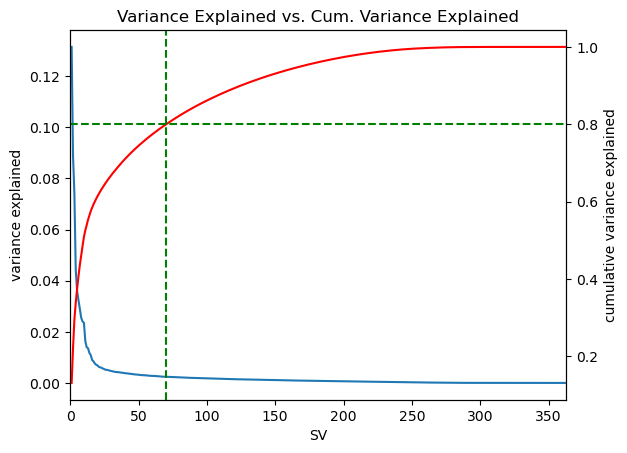

In [597]:
nssd_cum(nssd)

<center><b>Figure 15.</b> Variance Explained vs. Cum Variance Explained</center>

Given a threshold of 80%, the needed singular values to explain most of the variance is <b>71 singular values.</b>

In [612]:
%%capture
nssd.cumsum()[70] # Add 1

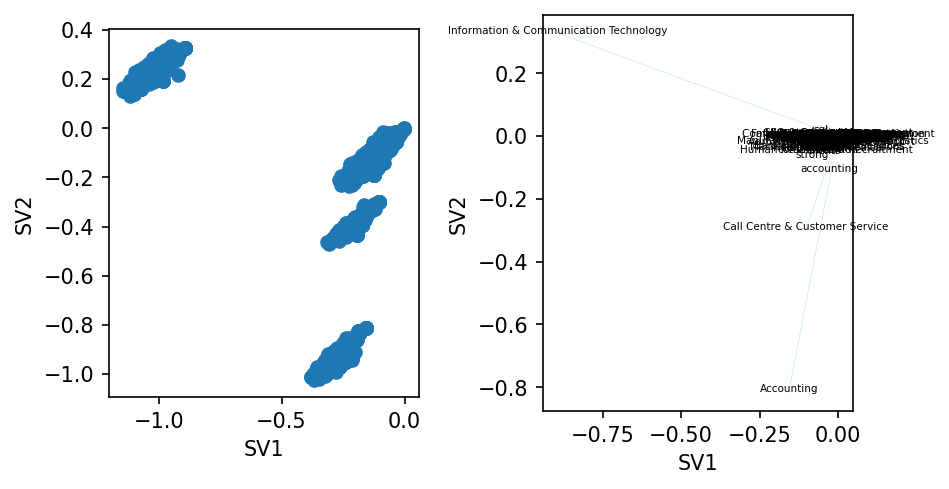

In [576]:
X_new = new_df.to_numpy().dot(p[:, :2])
plot_svd(X_new, new_df.columns, p)

<center><b>Figure 16.</b> SVD Plot (Scatter and Feature Vector Arrows)</center>

Given this plot, while clusters can be seen across the plot wherein there are two clusters in the middle of SV2 and lower end  of SV1 (zero), one cluster in the lower ends of both SVs (negative for SV2 and zero for SV1, respectively), and another cluster in the positive upper end of SV2 and negative "upper" end of SV1, it would be hard to interpret the singular values using this plot alone given the numerous features, and so, to interpret each singular value, the first 10 singular values would be plotted using bar graphs and word clouds.

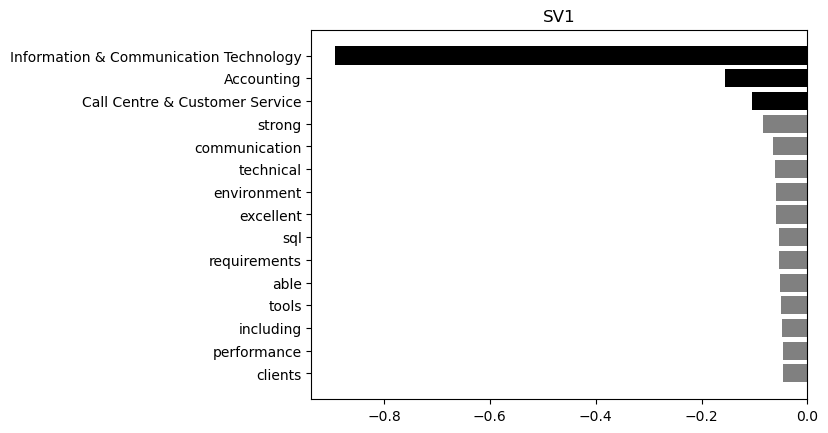

In [631]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 0]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 0],
       color=['gray', 'gray', 'gray', 'gray', 'gray', 'gray',
              'gray', 'gray', 'gray', 'gray', 'gray', 'gray',
              'black', 'black', 'black'])
ax.set_title(f'SV{0+1}')
plt.show()

<center><b>Figure 17.</b> SV1 Horizontal Bar Chart</center>

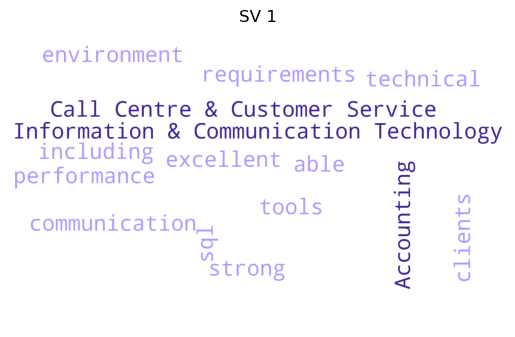

In [615]:
word_cloud_svd(0)

<center><b>Figure 18.</b> SV1 Word Cloud</center>

<b>SV1 - Technical Client Support Roles</b><br>
The top segments which are hiring data-related roles are from the Information & Communication Technology, Accounting, and Call Centre & Customer Service.

The needed skills for these group of segments are:
<ul>
    <li>Should be a a strong communicator</li>
    <li>Should have technical skills and knowledge of relevant tools</li>
    <li>Must know SQL</li>
    <li>Should be able to deal with clients</li>
</ul>

The desired hiree for this should both be technically knowledgeable and a strong communicator, especially with clients.


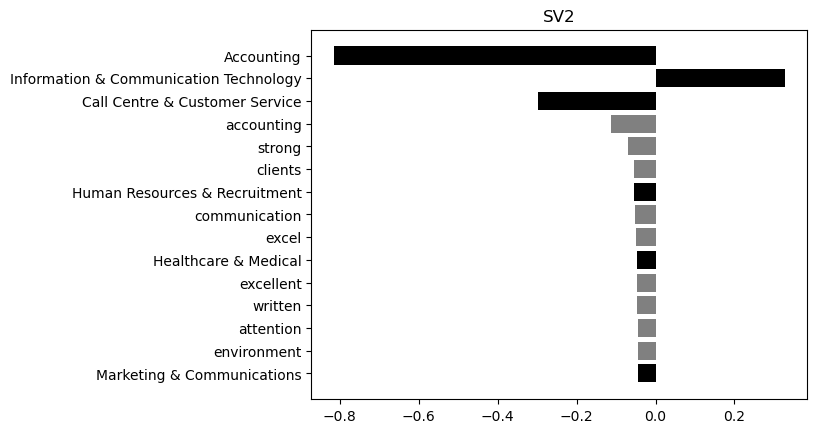

In [630]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 1]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 1],
       color=['black', 'gray', 'gray', 'gray', 'gray', 'black',
              'gray', 'gray', 'black', 'gray', 'gray', 'gray',
              'black', 'black', 'black'])
ax.set_title(f'SV{1+1}')
plt.show()

<center><b>Figure 19.</b> SV2 Horizontal Bar Chart</center>

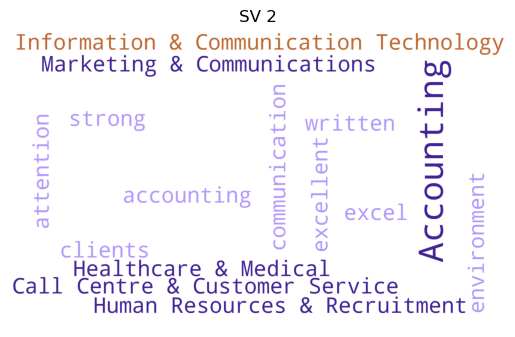

In [617]:
word_cloud_svd(1)

<center><b>Figure 20.</b> SV2 Word Cloud</center>

<b>SV2 - Client-Centric Business Services Roles</b><br>
On the left side of the axis, the top segments include Accounting, Call Centre & Customer Service, Human Resources & Recruitment and Healthcare & Medical.

The needed skills for these group of segments are:
<ul>
    <li>Have Accounting or financial knowledge</li>
    <li>Should be a a strong communicator</li>
    <li>Should be able to deal with clients</li>
    <li>Must know Excel</li>
    <li>Have attention to detail</li>
    <li>Must be good in written communication</li>
</ul>
The desired hiree for this should also be technically knowledgeable and be a strong communicator, on top of having knowledge of a more common tool, Excel.


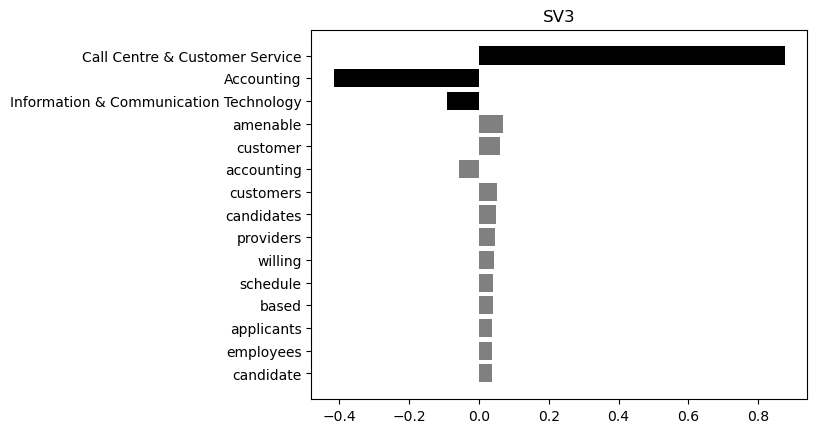

In [632]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 2]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 2],
       color=['gray', 'gray', 'gray', 'gray', 'gray', 'gray',
              'gray', 'gray', 'gray', 'gray', 'gray', 'gray',
              'black', 'black', 'black'])
ax.set_title(f'SV{2+1}')
plt.show()

<center><b>Figure 21.</b> SV3 Horizontal Bar Chart</center>

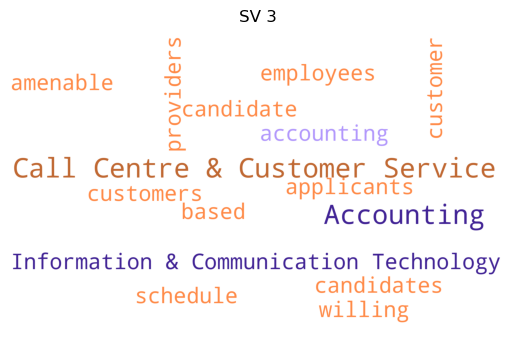

In [633]:
word_cloud_svd(2)

<center><b>Figure 22.</b> SV3 Word Cloud</center>

<b>SV3 - Customer-centric Professions</b><br>
On the right side of the axis, the top segment includes Call Centre & Customer Service.

The needed skills for this segment are:
<ul>
    <li>Be amenable or friendly</li>
    <li>Be customer-centric</li>
    <li>Be organized</li>
</ul>
Hirees in the Call Centre & Customer Service segment deal a lot with customers, and so their needed hire has to have the capacity to deal with people. 


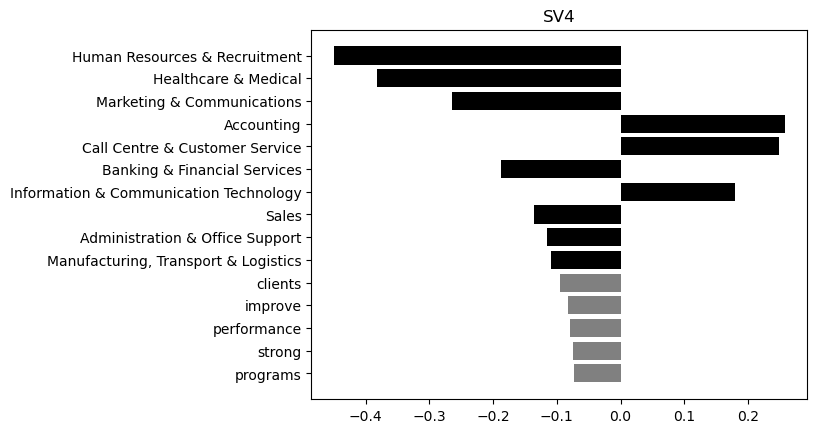

In [636]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 3]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 3],
       color=['gray', 'gray', 'gray', 'gray', 'gray', 'black',
              'black', 'black', 'black', 'black', 'black', 'black',
              'black', 'black', 'black'])
ax.set_title(f'SV{3+1}')
plt.show()

<center><b>Figure 23.</b> SV4 Horizontal Bar Chart</center>

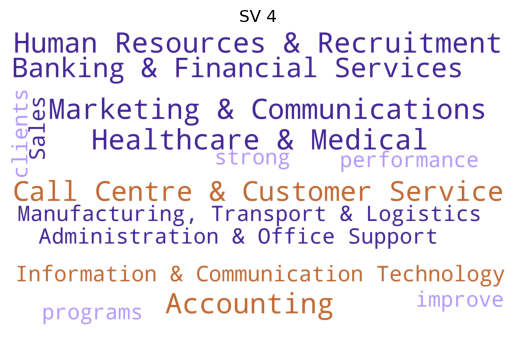

In [620]:
word_cloud_svd(3)

<center><b>Figure 24.</b> SV4 Word Cloud</center>

<b>SV4 - Client-centric Professions</b><br>
On the left side of the axis, the top segments include Human Resources & Recruitment, Healthcare & Medical, Marketing & Communications, Banking & Financial Services, Sales, Administration & Office Support, Manufacturing, Transport & Logistics.

The skills associated with this group is:
<ul>
<li>Must be able to deal with clients</li>
<li>Must be able to improve performance that satisfies clients</li>
</ul>

Note that in the opposing axis here, the top segments include: Accounting, Call Centre & Customer Service, and Information & Communication Technology. These segments were previously seen in SV1, which may mean that those in these segments are opposed to that of SV1.

In SV4, the hirees in these segments give a strong emphasis to working with clients, while those segments in SV1 give a balance to being technically-inclined while still communicating with clients.

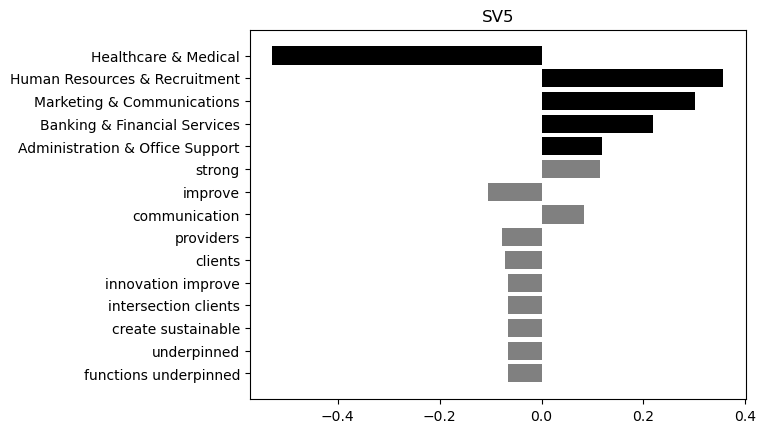

In [637]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 4]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 4],
       color=['gray', 'gray', 'gray', 'gray', 'gray', 'gray',
              'gray', 'gray', 'gray', 'gray', 'black', 'black',
              'black', 'black', 'black'])
ax.set_title(f'SV{4+1}')
plt.show()

<center><b>Figure 25.</b> SV5 Horizontal Bar Chart</center>

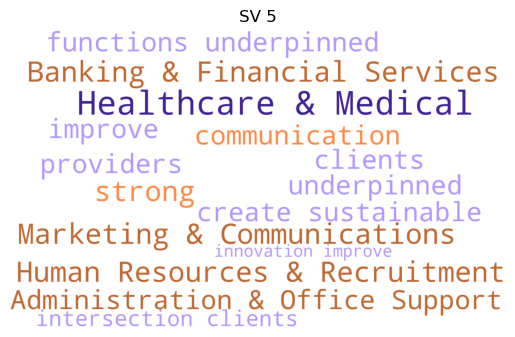

In [622]:
word_cloud_svd(4)

<center><b>Figure 26.</b> SV5 Word Cloud</center>

<b>SV5 - Empathy-Communication Spectrum</b><br>
The left side of the axis includes the segment Healthcare & Medical with the skills:
<ul>
    <li>Must be willing to improve lives</li>
</ul>

On the other side of the axis includes the segment Human Resources & Recruitment, Marketing & Communications, Banking & Financial Services, and Administration & Office Support with the skill:
<ul>
    <li>Must have strong communication skills</li>
</ul>
The spectrum represents the continuum between the desire to make a positive impact on people's lives and the importance of effectively conveying ideas and messages.

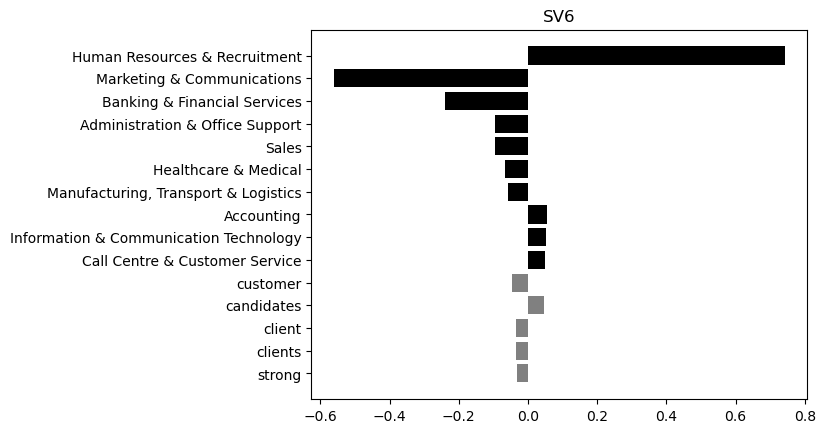

In [639]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 5]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 5],
       color=['gray', 'gray', 'gray', 'gray', 'gray', 'black',
              'black', 'black', 'black', 'black', 'black', 'black',
              'black', 'black', 'black'])
ax.set_title(f'SV{5+1}')
plt.show()

<center><b>Figure 27.</b> SV6 Horizontal Bar Chart</center>

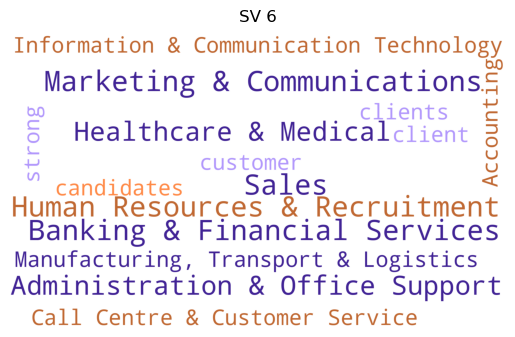

In [623]:
word_cloud_svd(5)

<center><b>Figure 28.</b> SV6 Word Cloud</center>

<b>SV6 - Serving Customers vs. Candidates</b><br>
The left side of the axis includes the following segments: Marketing & Communications, Banking & Financial Services, Administration & Office Support, Sales, Healthcare & Medical, Manufacturing, Transport & Logistics, who will handle mostly customers and clients.

The right side of the axis includes the following segments: Human Resources & Recruitment, Accounting, Information & Communication Technology, Call Centre & Customer Service, who will handle mostly candidates.

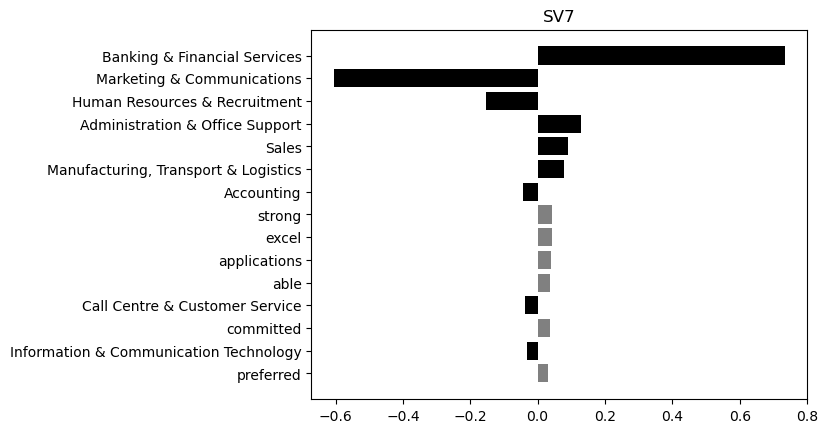

In [640]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 6]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 6],
       color=['gray', 'black', 'gray', 'black', 'gray', 'gray',
              'gray', 'gray', 'black', 'black', 'black', 'black',
              'black', 'black', 'black'])
ax.set_title(f'SV{6+1}')
plt.show()

<center><b>Figure 29.</b> SV7 Horizontal Bar Chart</center>

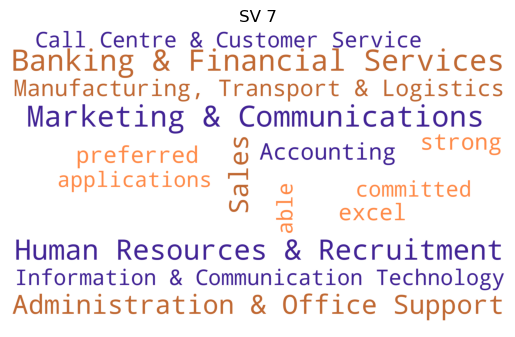

In [625]:
word_cloud_svd(6)

<center><b>Figure 30.</b> SV7 Word Cloud</center>

<b>SV7 - Service and Communication to Technical Expertise Spectrum</b><br>
The left side of the axis includes the following segments: Marketing & Communications, Human Resources & Recruitment, Accounting and Call Centre & Customer Service.

The right side of the axis includes the following segments: Banking & Financial Services, Administration & Office Support, Sales, Manufacturing, Transport & Logistics, which needs the skills:
<ul>
<li>Must know Excel</li>
<li>Must know industry-specific applications</li>
<li>Must have financial knowledge</li>
<li>Must be committed to improvement</li>
</ul>

These two sides of the spectrum emphasize the shifting focus from communication and service-oriented roles to those that require technical skills and industry-specific knowledge.

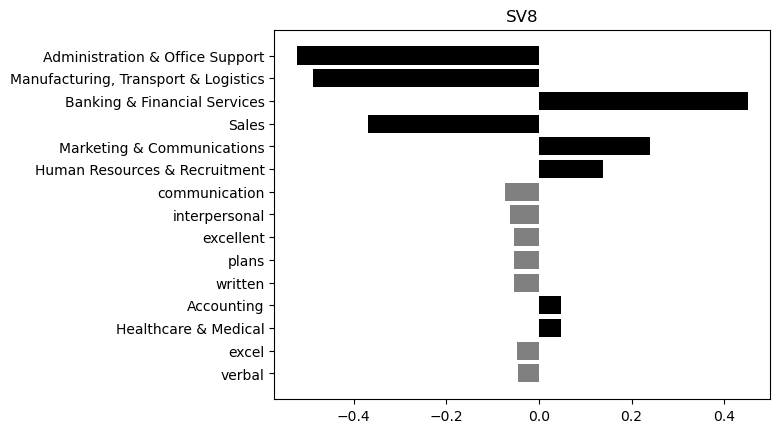

In [641]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 7]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 7],
       color=['gray', 'gray', 'black', 'black', 'gray', 'gray',
              'gray', 'gray', 'gray', 'black', 'black', 'black',
              'black', 'black', 'black'])
ax.set_title(f'SV{7+1}')
plt.show()

<center><b>Figure 31.</b> SV8 Horizontal Bar Chart</center>

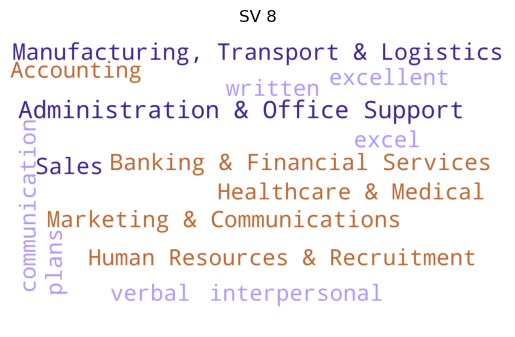

In [626]:
word_cloud_svd(7)

<center><b>Figure 32.</b> SV8 Word Cloud</center>

<b>SV8 - Technical Operations to Professional Services Continuum</b><br>
The left side of the axis includes the following segments: Administration & Office Support, Manufacturing, Transport & Logistics, Sales, and Engineering. The skills required here are:
<ul>
    <li>Have good interpersonal skills</li>
    <li>Have strong written and verbal communication skills</li>
    <li>Must know Excel</li>
    <li>Must be a good planner</li>
</ul>

The right side of the axis includes the following segments: Banking & Financial Services, Marketing & Communications, Human Resources & Recruitment, and Healthcare & Medical.

The axis highlights the spectrum from roles that emphasize operational and interpersonal skills to those focused on professional services in finance, marketing, HR, and healthcare.

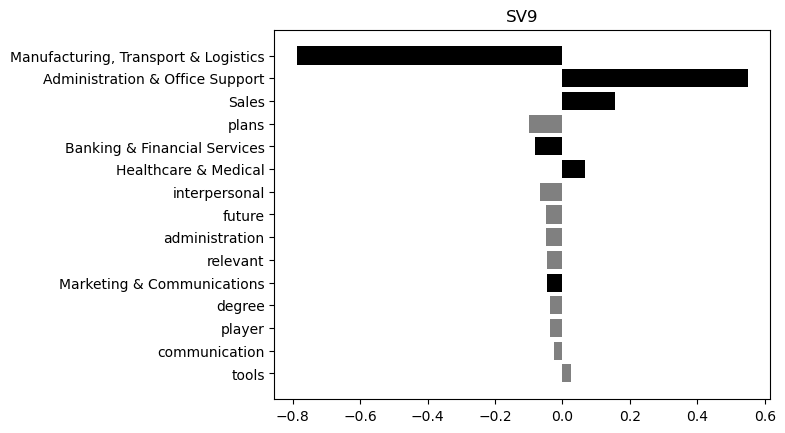

In [642]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 8]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 8],
       color=['gray', 'gray', 'gray', 'gray', 'black', 'gray',
              'gray', 'gray', 'gray', 'black', 'black', 'gray',
              'black', 'black', 'black'])
ax.set_title(f'SV{8+1}')
plt.show()

<center><b>Figure 33.</b> SV9 Horizontal Bar Chart</center>

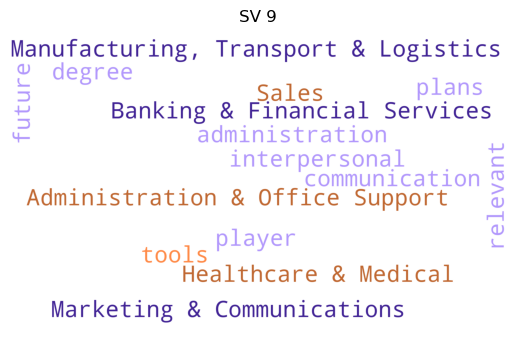

In [627]:
word_cloud_svd(8)

<center><b>Figure 34.</b> SV9 Word Cloud</center>

<b>SV9 - Strategic Leadership to Technical Expertise Continuum</b><br>
The left side of the axis includes the following segments:  Manufacturing, Transport & Logistics, Banking & Financial Services, and Marketing & Communications. The skills required here are:
<ul>
<li>Must be a good planner</li>
<li>Must have strong interpersonal skills</li>
<li>Must be future-thinking</li>
<li>Must be a team player</li>
<li>Must have strong communication skills</li>
</ul>

The right side of the axis includes the following segments: Administration & Office Support, Sales, and Healthcare & Medical, with the required skills:
<ul>
    <li>Must have knowledge with industry-specific tools</li>
</ul>

This spectrum highlight the range from roles that prioritize strategic planning and interpersonal skills to those that emphasize technical proficiency with industry-specific tools.


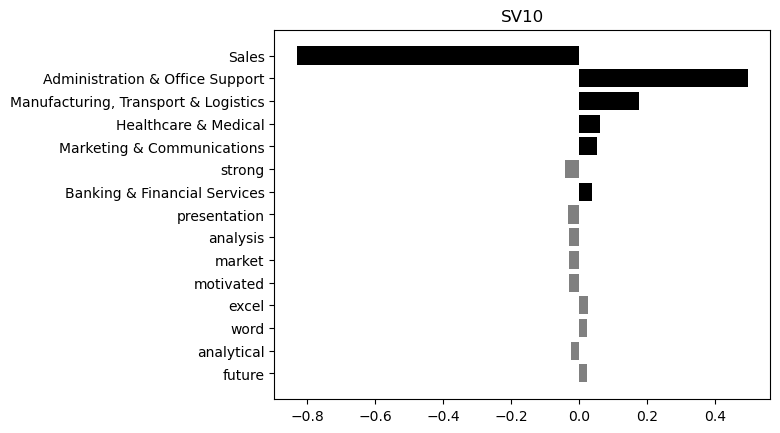

In [643]:
feature_names = new_df.columns
fig, ax = plt.subplots()
order = np.argsort(np.abs(p[:, 9]))[-15:]
ax.barh([feature_names[o] for o in order], p[order, 9],
       color=['gray', 'gray', 'gray', 'gray', 'gray', 'gray',
              'gray', 'gray', 'black', 'gray', 'black', 'black',
              'black', 'black', 'black'])
ax.set_title(f'SV{9+1}')
plt.show()

<center><b>Figure 35.</b> SV10 Horizontal Bar Chart</center>

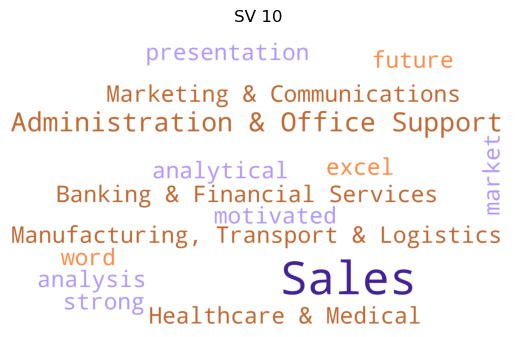

In [628]:
word_cloud_svd(9)

<center><b>Figure 36.</b> SV10 Word Cloud</center>

<b>SV10 - Analytical vs Administrative Professions</b><br>
The left side of the axis includes the segment Sales, with the required skills:
<ul>
    <li>Be motivated</li>
    <li>Have strong analytical skills</li>
    <li>Must have presentation skills</li>
</ul>

The right side of the axis includes the segments: Administration & Office Support, Manufacturing, Transport & Logistics, Healthcare & Medical, Marketing & Communications, Banking & Financial Services, with the required skills:
<ul>
    <li>Must know Excel and Word</li>
    <li>Must be future-thinking</li>
</ul>

This continuum aims to capture the range from roles that require motivation and analytical skills to those that prioritize administrative proficiency and future-thinking.

[Back to TOC](#TContents)

<a id='Conclusion'></a>
<img class='header' src='Pictures/conclusion.png'/>

<h2 style="color: #C00000">Summary and Insights</h2>

Shown here is a summary table of the results and discussion:

<p><b>Table 11.</b></p>
<p><i>Summary of Job-Skill Segments</i></p>

<table>
    <thead>
        <tr>
            <th><b>SV</b></th>
            <th><b>Job Segment</b></th>
            <th><b>Required Skills</b></th>
            <th><b>Summary</b></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>SV1</b></td>
            <td>Technical Client Support Roles</td>
            <td>- Strong communicator<br>- Technical skills and knowledge of relevant tools<br>- SQL proficiency<br>- Ability to deal with clients</td>
            <td>Hirees need to be technically knowledgeable and strong communicators, especially with clients.</td>
        </tr>
        <tr>
            <td><b>SV2</b></td>
            <td>Client-Centric Business Services Roles</td>
            <td>- Accounting or financial knowledge<br>- Strong communicator<br>- Ability to deal with clients<br>- Excel proficiency<br>- Attention to detail<br>- Good in written communication</td>
            <td>Desired hirees should be technically knowledgeable, strong communicators, and proficient in Excel.</td>
        </tr>
        <tr>
            <td><b>SV3</b></td>
            <td>Customer-Centric Professions</td>
            <td>- Amenable and friendly<br>- Customer-centric<br>- Organized</td>
            <td>The focus is on dealing with customers, requiring the ability to engage with people effectively.</td>
        </tr>
        <tr>
            <td><b>SV4</b></td>
            <td>Client-Centric Professions</td>
            <td>- Ability to deal with clients<br>- Improve performance that satisfies clients</td>
            <td>Emphasis on working with clients, providing a strong focus on client interaction.</td>
        </tr>
        <tr>
            <td><b>SV5</b></td>
            <td>Empathy-Communication Spectrum</td>
            <td>- Willingness to improve lives (Healthcare & Medical)<br>- Strong communication skills (HR, Marketing, Banking, Admin)</td>
            <td>Represents the continuum between making a positive impact on lives and effective communication.</td>
        </tr>
        <tr>
            <td><b>SV6</b></td>
            <td>Serving Customers vs. Candidates</td>
            <td>- Customer-centric roles (Marketing, Sales, Healthcare, etc.)<br>- Candidate-centric roles (HR, Accounting, IT, Call Centre)</td>
            <td>Highlights the distinction between roles focusing on customers/clients and those on candidates.</td>
        </tr>
        <tr>
            <td><b>SV7</b></td>
            <td>Service and Communication to Technical Expertise Spectrum</td>
            <td>- Communication-focused roles (Marketing, HR, Accounting, etc.)<br>- Technical roles (Banking, Manufacturing, Logistics, etc.)</td>
            <td>Emphasizes the shift from communication/service-oriented roles to those requiring technical expertise.</td>
        </tr>
        <tr>
            <td><b>SV8</b></td>
            <td>Technical Operations to Professional Services Continuum</td>
            <td>- Interpersonal skills<br>- Strong communication skills<br>- Excel proficiency<br>- Good planner (Admin, Manufacturing, Logistics, etc.)</td>
            <td>Represents the spectrum from roles emphasizing operational skills to those in professional services.</td>
        </tr>
        <tr>
            <td><b>SV9</b></td>
            <td>Strategic Leadership to Technical Expertise Continuum</td>
            <td>- Good planner<br>- Strong interpersonal skills<br>- Future-thinking<br>- Team player<br>- Strong communication skills (Manufacturing, Banking, Marketing, etc.)</td>
            <td>Captures the range from roles prioritizing strategic planning to those emphasizing technical expertise.</td>
        </tr>
        <tr>
            <td><b>SV10</b></td>
            <td>Analytical vs Administrative Professions</td>
            <td>- Motivation<br>- Analytical skills<br>- Presentation skills (Sales)<br>- Excel and Word proficiency<br>- Future-thinking (Admin, Manufacturing, Healthcare, etc.)</td>
            <td>Represents the continuum from roles requiring motivation and analytics to those emphasizing administrative proficiency.</td>
        </tr>
    </tbody>
</table>

These are some insights gleaned from the results of the study:

- The primary job segments in data-related positions emerge from the Accounting, Call Centre & Customer Service, and Information & Communication Technology domains.
- Working with clients and communication skills emerged as the persistent and prevailing skill wanted across many job segments.
- While career shifters and students focus on hard skills, it was shown here that employers value core competency and soft skills that help them solve their problems, rather than the specific technical skills.

To fully conclude the study, at the beginning, the team was expecting mostly technical skills to be the source of variance for needed job skills per segment. However, as shown here, most job-skill segments vary also by soft skills and core competencies such as strong communication skills and having an analytical mind. This further necessitates how future data professionals should not only focus on their technical know-how, but make sure that they also grow in terms of their soft skills and core competencies. This should also guide companies to know which soft skills, aside from hard skills, should be expected of a data professional entering a specific department of their company. 

[Back to TOC](#TContents)

<a id='Recommendation'></a>
<img class='header' src='Pictures/recommendation.png'/>

For the next set of studies, we recommend:

<ol>
    <li><b>Focus on hard skills</b><br>In this study, we found that soft skills and core competency are important skills to have for anyone wanting to go in this industry. Hard skills or the specific tools were not mentioned as much in the results, although the words "technical", "Excel" and "SQL" did come on the latter part of the results. Many will be curious to know what specific tools or fields of study in "data" will trend and be in-demand in the years to come.</li>
    <li><b>Focus on specific job titles</b><br>Data is all around us, and so are data-related jobs. The job titles here consisted of analysts, consultants, and data encoders and even accountants and customer service representatives who work with data. To make a more focused study serving a specific group in the industry, we recommend focusing on specific job titles of interest. Furthermore, not only the job titles can be filtered, but also varying features about the job (eg. salary, location).</li>
    <li><b>Use another data source aside from job posts</b><br>Job posts are free form text, which needs much data cleaning in order to generate specific insights of interest. In particular, the job posts, while enumerates skills and tools, also enumerate needed characteristics of the applicant (eg. being detail-oriented, amicable). To find the specific hard skills or toolset needed, it's possible to use a different set of data that would be more descriptive and niched to the data-related jobs of interest.</li>
</ol>

[Back to TOC](#TContents)

<a id='Acknowledgment'></a>
<img class='header' src='Pictures/acknowledgment.png'/>

We would like to extend our heartfelt gratitude to everyone who supported us throughout this project. Special thanks go to our mentor, Prof. Christian Alis for his invaluable guidance and encouragement. We are also grateful to our colleagues and peers for their insights and contributions, which greatly enriched our work. Additionally, we appreciate the understanding and support from our families and friends during this endeavor. This project would not have been possible without the collective effort and encouragement from all who were involved.

[Back to TOC](#TContents)

<a id='References'></a>
<img class='header' src='Pictures/ref.png'/>

<b>References</b>
<ol>
    <li>Davenport, T., Patil, D. (2022, July 15).  Is Data Scientist Still the Sexiest Job of the 21st Century?.   Harvard Business Review. https://hbr.org/2022/07/is-data-scientist-still-the-sexiest-job-of-the-21st-century?fbclid=IwAR08iUssthOE_mF4VkZKYZ2njPfkY6Aj6fCPYtwYp9_kLYsdVhMqi4mK_LQ</li>
    <li> Michael Page. (2023). The Invisible Revolution. Retrieved from https://www.michaelpage.com.ph/talent-trends/the-invisible-revolution </li>
    <li> Michael Page. (2023). 5 most in-demand tech roles for 2023. Retrieved from https://www.michaelpage.com.ph/advice/market-insights/market-updates/5-most-demand-tech-roles-2023 </li>
    <li>UCLA Institute for Digital Research and Education. (n.d.). Principal Components (PCA) and Exploratory Factor Analysis (EFA) with SPSS. Retrieved from https://stats.oarc.ucla.edu/spss/seminars/efa-spss/</li>
    <li>Yencken, L. (2011, December 6). stopwords.txt. Retrieved from https://gist.github.com/larsyencken/1440509</li>  
</ol>

[Back to TOC](#TContents)